# Find out top 10 Anomalous records using PCA & Autoencoder
Yi-Hsin (Amy) Chung

# Summary
## Step 1: Perform PCA on 45 variables
    1. After performing PCA, I chose the top 8 PCs (explain about 95% of the variance) to do the rest of the analysis.
    2. Standardized these 8 PCs --> zscores
## Step 2: Calculate Fraud_Score_1 using Heuristic Function of the zscores
    I use n = 2, which is the Euclidean distance:
    Fraud_score_1 = the square root of the sum of (Xi)**2 for each record
## Step 3: Perform Autoencoder on the 8 standardized PCs from Step 1
    1. I use Keras package to run Autoencoder Model, 3 layers, and the number of nodes are 8 -> 4 -> 8
    2. For the hidden layer, I choose dimension = 4
    3. Activation function is linear, which is F(X) = X
    4. When training the model, I use nb_epoch = 20, batch_size = 1000
    5. After training the model, use the model to predict X, and we can get a new table consisting of reconstructed X, which are the output of the Autoencoder Model
## Step 4: Calculate Fraud_Score_2 from the results of Autoencoder Model
    I use n = 2, which is the Euclidean distance:
    Set the original standardized PCs value = old_Xi, 
        the reconstructed X from autoencoder model = new_Xi
    For each record, Fruad_score_2 = the square root of the sum of (old_Xi - new_Xi)**2
## Step 5: Generate the final ranking for each record
    1. rank desceding by Fraud_Score_1, called rank_1
    2. rank desceding by Fraud_Score_2, called rank_2
    3. generate final ranking by taking the weighted average of rank_1 and rank_2 (I use weight = 0.5)
## Step 6: Merge the final_rank and RECORD to the 45 variables dataset
## Step 7: Find out the top 10 fruad records
    Sort the combined data from Step 6 by final_rank, and look at the top 10 records
    The top 10 anomalous records have RECORD value of:
    1. 632816
    2. 565392
    3. 1067360
    4. 917942
    5. 556609
    6. 85886
    7. 585118
    8. 585439
    9. 750816
    10. 185809

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
#from sklearn.preprocessing import MinMaxScaler

In [2]:
# read data file with 45 variables (already standardized)
mydata = pd.read_csv("nor_new_45.csv")
print(mydata.shape)
mydata.head()

(1070994, 45)


,r1_all,r1_zip5,r1_zip3,r1_TAXCLASS,r1_B,r2_all,r2_zip5,r2_zip3,r2_TAXCLASS,r2_B,...,r8_all,r8_zip5,r8_zip3,r8_TAXCLASS,r8_B,r9_all,r9_zip5,r9_zip3,r9_TAXCLASS,r9_B
0,-0.158695,-0.236201,-0.135153,-0.143767,-0.133590,0.010989,0.068317,0.015784,-0.000483,0.016332,...,0.066444,0.042397,0.021663,-0.002639,0.020130,-0.013356,-0.048033,-0.016757,-0.011541,-0.016390
1,31.894268,27.256834,13.619209,25.481489,13.831979,0.695904,1.592958,0.840474,0.333776,0.782003,...,0.753801,0.884952,0.372464,0.301400,0.337618,0.016663,-0.002216,0.010243,-0.007462,0.011310
2,0.045721,-0.060866,-0.047436,0.019656,-0.044525,-0.041305,-0.048090,-0.047181,-0.026004,-0.042127,...,0.013964,-0.021933,-0.005121,-0.025853,-0.004111,0.006823,-0.017235,0.001392,-0.008799,0.002230
3,-0.113536,-0.197466,-0.115775,-0.107664,-0.113914,0.030594,0.111958,0.039390,0.009085,0.038249,...,0.086119,0.066514,0.031704,0.006064,0.029217,0.097558,0.121249,0.083001,0.003529,0.085952
4,0.422644,0.262436,0.114307,0.320994,0.119701,6.635567,14.814811,7.992274,3.232508,7.421985,...,6.714629,8.191684,3.414653,2.938063,3.090910,14.687012,22.388087,13.204917,1.985730,13.547709


## Step 1: Perform PCA on 45 variables

In [3]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(mydata)

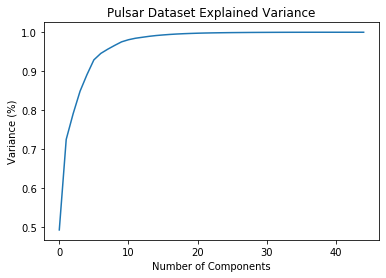

In [4]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [5]:
# Look at the percentage of variance explained by the top PCs
top = 8
var_ratio = list(pca.explained_variance_ratio_)
var_ratio.sort(reverse=True)
top_pc = var_ratio[:top]
#print(top_pc)
explained_var = sum(top_pc)
print(f"The percentage of variance explained by the top {top} PCs is", explained_var)

The percentage of variance explained by the top 8 PCs is 0.9564398455140141


### The top 8 PCs explained about 95.64% of the variance.
### I decided to use these 8 component to do the rest of the analysis
1. z-score these 8 principle component
2. calculate fraud_score_1
3. run Autoencoder model
4. calculate fraud_score_2
5. combine fraud_score_1 and fraud_score_2

In [6]:
# run PCA with 8 component
pca8 = PCA(n_components=8)
dataset = pca8.fit_transform(mydata)
dataset

array([[-1.00798535e-01, -3.72678224e-01, -2.01731775e-01, ...,
        -1.83599559e-02,  6.32427927e-02, -6.73884025e-02],
       [ 1.56921019e+01,  6.88702391e+01,  8.98689528e+00, ...,
        -1.10607869e+00, -4.15508423e-01, -4.25710720e+01],
       [ 1.94690253e-02,  3.13910896e-01, -1.32343383e-01, ...,
        -1.15256606e-01,  1.24286829e-01, -3.61258028e-01],
       ...,
       [-1.40798090e-01, -4.03270325e-01, -8.23543148e-02, ...,
        -6.61933746e-02,  9.92033815e-02,  4.00218822e-02],
       [-9.22302648e-02, -3.30243524e-01, -5.88025005e-02, ...,
        -8.01550327e-02,  1.01263657e-01,  5.75918953e-02],
       [-1.00369433e-01, -2.23656288e-01, -2.10193997e-02, ...,
        -4.20825749e-02,  1.04190538e-01,  6.72510851e-02]])

In [7]:
# standardized these 8 columns
scaler = preprocessing.StandardScaler().fit(dataset)

In [8]:
pca_standard = scaler.transform(dataset)
pca_standard

array([[-2.14099322e-02, -1.15264727e-01, -1.17184330e-01, ...,
        -1.40434070e-02,  7.32431959e-02, -9.66991589e-02],
       [ 3.33305278e+00,  2.13007061e+01,  5.22041358e+00, ...,
        -8.46032164e-01, -4.81211589e-01, -6.10874675e+01],
       [ 4.13528342e-03,  9.70887257e-02, -7.68771830e-02, ...,
        -8.81590037e-02,  1.43939952e-01, -5.18388123e-01],
       ...,
       [-2.99059659e-02, -1.24726483e-01, -4.78389444e-02, ...,
        -5.06308677e-02,  1.14890130e-01,  5.74295012e-02],
       [-1.95900041e-02, -1.02140204e-01, -3.41578891e-02, ...,
        -6.13100462e-02,  1.17276191e-01,  8.26416360e-02],
       [-2.13187896e-02, -6.91741010e-02, -1.22099965e-02, ...,
        -3.21886789e-02,  1.20665891e-01,  9.65021149e-02]])

In [9]:
# transform the array into pd.dataframe, this is the dataset we want to use for deriving score_1 and Autoencoder
pca_std_data = pd.DataFrame(data = pca_standard, columns = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8"])
pca_std_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.021410,-0.115265,-0.117184,0.047773,-0.077461,-0.014043,0.073243,-0.096699
1,3.333053,21.300706,5.220414,-5.958547,-0.555355,-0.846032,-0.481212,-61.087468
2,0.004135,0.097089,-0.076877,0.156660,-0.019225,-0.088159,0.143940,-0.518388
3,0.073088,-0.087687,-0.103938,0.073236,0.140684,-0.012397,0.167421,-0.119344
4,13.046618,-3.397512,-0.067988,-2.603168,28.684502,2.262345,9.238565,8.063124


## Step 2: Calculate Fraud_Score_1 using Heuristic Function of the zscores

In [10]:
# calculate the fraud_1 using Euclidean distance, n = 2
pc = list(pca_std_data.columns)
pca_std_data["fraud_1"] = [0]*len(pca_std_data)
n = 2
for p in pc:
    pca_std_data["fraud_1"] += pca_std_data[p]**n
pca_std_data["fraud_1"] = pca_std_data["fraud_1"]**(1/n)
pca_std_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,fraud_1
0,-0.021410,-0.115265,-0.117184,0.047773,-0.077461,-0.014043,0.073243,-0.096699,0.225103
1,3.333053,21.300706,5.220414,-5.958547,-0.555355,-0.846032,-0.481212,-61.087468,65.272665
2,0.004135,0.097089,-0.076877,0.156660,-0.019225,-0.088159,0.143940,-0.518388,0.580932
3,0.073088,-0.087687,-0.103938,0.073236,0.140684,-0.012397,0.167421,-0.119344,0.302351
4,13.046618,-3.397512,-0.067988,-2.603168,28.684502,2.262345,9.238565,8.063124,34.158782


## Step 3: Perform Autoencoder on the 8 standardized PCs from Step 1

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [12]:
import keras
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [13]:
# extract PC1 to PC8 from pca_std_data, used as the input for antoencoder model
X = pca_std_data.iloc[:,:8]
X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.021410,-0.115265,-0.117184,0.047773,-0.077461,-0.014043,0.073243,-0.096699
1,3.333053,21.300706,5.220414,-5.958547,-0.555355,-0.846032,-0.481212,-61.087468
2,0.004135,0.097089,-0.076877,0.156660,-0.019225,-0.088159,0.143940,-0.518388
3,0.073088,-0.087687,-0.103938,0.073236,0.140684,-0.012397,0.167421,-0.119344
4,13.046618,-3.397512,-0.067988,-2.603168,28.684502,2.262345,9.238565,8.063124


In [14]:
# setting up the attribute of Autoencoder Model
ncol = 8
# specify the dimension of input, which is 8 in our case (8 columns)
input_dim = Input(shape = (ncol, ))
# set the hidden layer to have 4 dimensions or 4 nodes
encoding_dim = 4
# DEFINE THE ENCODER and DECODER LAYER
encoded = Dense(encoding_dim)(input_dim)
decoded = Dense(ncol)(encoded)

In [15]:
# initialize the Autoencoder Model
autoencoder = Model(input = input_dim, output = decoded)
# CONFIGURE AND TRAIN THE AUTOENCODER
# I use 20 epoch and batch_size of 1000, we can see that the loss (mean square error) decreases as running each epoch
autoencoder.compile(optimizer = 'adam', loss = 'mse')
autoencoder.fit(X, X, nb_epoch = 20, batch_size = 1000, shuffle = True)

/Users/wan22601/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
/Users/wan22601/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/20
1070994/1070994 [==============================] - 3s 2us/step - loss: 1.4930
Epoch 2/20
1070994/1070994 [==============================] - 2s 2us/step - loss: 1.1458
Epoch 3/20
1070994/1070994 [==============================] - 2s 2us/step - loss: 0.9526A: 0s -
Epoch 4/20
1070994/1070994 [==============================] - 2s 2us/step - loss: 0.8141
Epoch 5/20
1070994/1070994 [==============================] - 2s 2us/step - loss: 0.7238
Epoch 6/20
1070994/1070994 [==============================] - 2s 2us/step - loss: 0.6544
Epoch 7/20
1070994/1070994 [==============================] - 2s 2us/step - loss: 0.6078
Epoch 8/20
1070994/1070994 [==============================] - 2s 2us/step - loss: 0.5688
Epoch 9/20
1070994/1070994 [==============================] - 2s 2us/step - loss: 0.5419
Epoch 10/20
1070994/1070994 [==============================] - 2s 2us/step - loss: 0.5276
Epoch 11/20
1070994/1070994 [==============================] - 2s 2us/step - loss: 0.5203
Epoch 12/20


In [16]:
# use the trained autoencoder to reconstruct X, F(X) = X
# save the results in encoded_out
encoded_out = autoencoder.predict(X)
encoded_out

array([[-7.3673688e-03,  1.0476076e-02,  8.1060613e-03, ...,
         1.2137247e-02, -1.9267330e-02, -2.2214508e-02],
       [-6.2885842e+00, -1.7569315e+00,  2.2238308e+01, ...,
         1.3135523e+01, -7.1597729e+00, -4.5361282e+01],
       [-1.0048150e-01,  1.4308332e-02,  1.4113048e-01, ...,
         5.6732371e-02, -9.3430199e-02, -3.2479930e-01],
       ...,
       [-2.4410039e-02,  9.4559034e-03, -3.3711344e-02, ...,
        -4.3851919e-02,  7.3600854e-03,  7.4759647e-02],
       [-2.0764440e-02,  3.5213763e-03, -3.6800921e-02, ...,
        -5.0995082e-02,  2.0920558e-02,  9.3220256e-02],
       [-2.7253680e-02,  1.8291466e-02, -3.5514124e-02, ...,
        -2.6343280e-02,  2.9634207e-02,  9.5735095e-02]], dtype=float32)

In [17]:
# transform encoded_out array into pd.DataFrame, named encode_data
encode_data = pd.DataFrame(data = encoded_out, columns = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8"])
encode_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.007367,0.010476,0.008106,0.025088,0.001272,0.012137,-0.019267,-0.022215
1,-6.288584,-1.756932,22.238308,-1.926231,1.338724,13.135523,-7.159773,-45.361282
2,-0.100482,0.014308,0.141130,0.125429,0.044132,0.056732,-0.093430,-0.324799
3,0.028857,-0.041767,0.012390,0.012408,0.070245,-0.052690,-0.048601,-0.045136
4,9.060885,-8.408508,-2.778776,-6.759650,8.812637,-10.450937,-1.975610,4.919377


## Step 4: Calculate Fraud_Score_2 from the results of Autoencoder Model

In [18]:
# The standardized PCA table, which is the input for performing autoencoder
# The output table is encode_data, which is in the previous cell
pca_std_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,fraud_1
0,-0.021410,-0.115265,-0.117184,0.047773,-0.077461,-0.014043,0.073243,-0.096699,0.225103
1,3.333053,21.300706,5.220414,-5.958547,-0.555355,-0.846032,-0.481212,-61.087468,65.272665
2,0.004135,0.097089,-0.076877,0.156660,-0.019225,-0.088159,0.143940,-0.518388,0.580932
3,0.073088,-0.087687,-0.103938,0.073236,0.140684,-0.012397,0.167421,-0.119344,0.302351
4,13.046618,-3.397512,-0.067988,-2.603168,28.684502,2.262345,9.238565,8.063124,34.158782


In [19]:
# create a new column fraud_2 with initial value = 0
cols = list(encode_data.columns)
pca_std_data["fraud_2"] = [0]*len(pca_std_data)
pca_std_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,fraud_1,fraud_2
0,-0.021410,-0.115265,-0.117184,0.047773,-0.077461,-0.014043,0.073243,-0.096699,0.225103,0
1,3.333053,21.300706,5.220414,-5.958547,-0.555355,-0.846032,-0.481212,-61.087468,65.272665,0
2,0.004135,0.097089,-0.076877,0.156660,-0.019225,-0.088159,0.143940,-0.518388,0.580932,0
3,0.073088,-0.087687,-0.103938,0.073236,0.140684,-0.012397,0.167421,-0.119344,0.302351,0
4,13.046618,-3.397512,-0.067988,-2.603168,28.684502,2.262345,9.238565,8.063124,34.158782,0


In [20]:
#encode_data.head()

In [21]:
# take the difference between the values in encode_data and those in pca_std_data
# save the square root of the sum of the differences in a new column called fraud_2
# I used n = 2
n = 2
for col in cols:
    pca_std_data["fraud_2"] += (pca_std_data[col] - encode_data[col])**n
pca_std_data["fraud_2"] = pca_std_data["fraud_2"]**(1/n)
pca_std_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,fraud_1,fraud_2
0,-0.021410,-0.115265,-0.117184,0.047773,-0.077461,-0.014043,0.073243,-0.096699,0.225103,0.230675
1,3.333053,21.300706,5.220414,-5.958547,-0.555355,-0.846032,-0.481212,-61.087468,65.272665,37.697299
2,0.004135,0.097089,-0.076877,0.156660,-0.019225,-0.088159,0.143940,-0.518388,0.580932,0.430266
3,0.073088,-0.087687,-0.103938,0.073236,0.140684,-0.012397,0.167421,-0.119344,0.302351,0.282939
4,13.046618,-3.397512,-0.067988,-2.603168,28.684502,2.262345,9.238565,8.063124,34.158782,27.527809


## Step 5: Generate the final ranking for each record

In [22]:
# create 2 rank column, rank_1 and rank_2, based on frand_1 and fraud_2
pca_std_data["rank_1"] = pca_std_data["fraud_1"].rank(ascending=False)
pca_std_data["rank_2"] = pca_std_data["fraud_2"].rank(ascending=False)
pca_std_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,fraud_1,fraud_2,rank_1,rank_2
0,-0.021410,-0.115265,-0.117184,0.047773,-0.077461,-0.014043,0.073243,-0.096699,0.225103,0.230675,327603.0,113889.0
1,3.333053,21.300706,5.220414,-5.958547,-0.555355,-0.846032,-0.481212,-61.087468,65.272665,37.697299,134.0,164.0
2,0.004135,0.097089,-0.076877,0.156660,-0.019225,-0.088159,0.143940,-0.518388,0.580932,0.430266,59414.0,52595.0
3,0.073088,-0.087687,-0.103938,0.073236,0.140684,-0.012397,0.167421,-0.119344,0.302351,0.282939,124701.0,80137.0
4,13.046618,-3.397512,-0.067988,-2.603168,28.684502,2.262345,9.238565,8.063124,34.158782,27.527809,255.0,216.0


In [23]:
# use weighted average to combine rank_1 and rank_2 for the final ranking
# I use weight = 0.5, which equals to the mean of rank_1 and rank_2
weight = 0.5
pca_std_data["final_rank"] = pca_std_data["rank_1"]*weight + pca_std_data["rank_2"]*(1-weight)
pca_std_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,fraud_1,fraud_2,rank_1,rank_2,final_rank
0,-0.021410,-0.115265,-0.117184,0.047773,-0.077461,-0.014043,0.073243,-0.096699,0.225103,0.230675,327603.0,113889.0,220746.0
1,3.333053,21.300706,5.220414,-5.958547,-0.555355,-0.846032,-0.481212,-61.087468,65.272665,37.697299,134.0,164.0,149.0
2,0.004135,0.097089,-0.076877,0.156660,-0.019225,-0.088159,0.143940,-0.518388,0.580932,0.430266,59414.0,52595.0,56004.5
3,0.073088,-0.087687,-0.103938,0.073236,0.140684,-0.012397,0.167421,-0.119344,0.302351,0.282939,124701.0,80137.0,102419.0
4,13.046618,-3.397512,-0.067988,-2.603168,28.684502,2.262345,9.238565,8.063124,34.158782,27.527809,255.0,216.0,235.5


In [24]:
# sort by final_rank, and show the top 10 records with the highest rank
pca_std_data.sort_values("final_rank").head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,fraud_1,fraud_2,rank_1,rank_2,final_rank
565391,298.106064,549.553630,-329.795107,436.287386,-10.213860,-280.143148,423.839904,-24.087165,974.059997,831.920159,2.0,1.0,1.5
632815,733.552113,-258.486733,547.420746,190.770818,-271.070480,-164.437521,-75.306084,-24.278301,1023.599735,752.374774,1.0,2.0,1.5
1067359,78.920866,606.118661,356.247570,-362.630231,-37.538841,201.754281,45.104929,352.406142,894.628330,706.043373,3.0,3.0,3.0
85885,249.949663,-74.412982,0.307252,-48.681365,478.045754,37.230887,187.145834,174.500457,604.789178,479.328584,6.0,4.0,5.0
917941,244.798249,-6.782593,-257.696941,148.199777,-236.356036,607.426361,-113.624437,-5.879818,765.584168,330.746215,4.0,8.0,6.0
556608,41.626918,184.429577,-82.804657,160.314758,48.578718,-106.069548,-416.751066,87.588940,513.096888,380.760486,7.0,5.0,6.0
585117,190.043590,-41.377330,-366.235544,-290.903744,-332.895340,22.738137,89.656811,168.256998,635.820103,347.159475,5.0,7.0,6.0
585438,157.110736,-41.725243,-282.370576,-318.665462,-158.534820,-88.648421,-101.886834,34.500462,502.263515,350.984428,8.0,6.0,7.0
750815,25.683101,214.296833,184.488110,-214.663859,-19.329776,133.525669,24.070303,-107.865862,396.379058,234.078848,10.0,10.0,10.0
185808,12.603625,76.550321,-30.610118,64.842490,16.128208,-47.316775,-309.610205,106.782217,347.735889,284.668588,12.0,9.0,10.5


## Step 6: Merge the final_rank results and RECORD to the 45 variables dataset

In [25]:
# combine 45 variables with the final_rank, fraud_1, fraud_2, rank_1, rank_2
# read data file with 45 variables (already standardized)
combine_data = pd.read_csv("nor_new_45.csv")
cols = ["fraud_1", "fraud_2", "rank_1", "rank_2", "final_rank"]
for col in cols:
    combine_data[col] = pca_std_data[col]
combine_data.head()

,r1_all,r1_zip5,r1_zip3,r1_TAXCLASS,r1_B,r2_all,r2_zip5,r2_zip3,r2_TAXCLASS,r2_B,...,r9_all,r9_zip5,r9_zip3,r9_TAXCLASS,r9_B,fraud_1,fraud_2,rank_1,rank_2,final_rank
0,-0.158695,-0.236201,-0.135153,-0.143767,-0.133590,0.010989,0.068317,0.015784,-0.000483,0.016332,...,-0.013356,-0.048033,-0.016757,-0.011541,-0.016390,0.225103,0.230675,327603.0,113889.0,220746.0
1,31.894268,27.256834,13.619209,25.481489,13.831979,0.695904,1.592958,0.840474,0.333776,0.782003,...,0.016663,-0.002216,0.010243,-0.007462,0.011310,65.272665,37.697299,134.0,164.0,149.0
2,0.045721,-0.060866,-0.047436,0.019656,-0.044525,-0.041305,-0.048090,-0.047181,-0.026004,-0.042127,...,0.006823,-0.017235,0.001392,-0.008799,0.002230,0.580932,0.430266,59414.0,52595.0,56004.5
3,-0.113536,-0.197466,-0.115775,-0.107664,-0.113914,0.030594,0.111958,0.039390,0.009085,0.038249,...,0.097558,0.121249,0.083001,0.003529,0.085952,0.302351,0.282939,124701.0,80137.0,102419.0
4,0.422644,0.262436,0.114307,0.320994,0.119701,6.635567,14.814811,7.992274,3.232508,7.421985,...,14.687012,22.388087,13.204917,1.985730,13.547709,34.158782,27.527809,255.0,216.0,235.5


In [26]:
# read the dataset with RECORD field
old_data = pd.read_csv("NY_cleaned.csv")
old_data.head()

,RECORD,ZIP_new,STORIES,TAXCLASS,B,FULLVAL,AVLAND,AVTOT,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH
0,1,10004,50.0,4,1,21400000.0,4225500.0,9630000.0,500.0,1046.0,152.0,207.0
1,2,10004,50.0,4,1,193800000.0,14310000.0,87210000.0,27.0,207.0,152.0,207.0
2,3,10004,3.0,4,1,104686000.0,39008700.0,47108700.0,709.0,564.0,709.0,564.0
3,4,10004,2.0,4,1,39200000.0,15255000.0,17640000.0,793.0,551.0,85.0,551.0
4,5,10004,1.0,4,1,272300000.0,121050000.0,122535000.0,323.0,1260.0,89.0,57.0


In [27]:
# combine RECORD field to the combine_data
combine_data["RECORD"] = old_data["RECORD"]
combine_data.head()

,r1_all,r1_zip5,r1_zip3,r1_TAXCLASS,r1_B,r2_all,r2_zip5,r2_zip3,r2_TAXCLASS,r2_B,...,r9_zip5,r9_zip3,r9_TAXCLASS,r9_B,fraud_1,fraud_2,rank_1,rank_2,final_rank,RECORD
0,-0.158695,-0.236201,-0.135153,-0.143767,-0.133590,0.010989,0.068317,0.015784,-0.000483,0.016332,...,-0.048033,-0.016757,-0.011541,-0.016390,0.225103,0.230675,327603.0,113889.0,220746.0,1
1,31.894268,27.256834,13.619209,25.481489,13.831979,0.695904,1.592958,0.840474,0.333776,0.782003,...,-0.002216,0.010243,-0.007462,0.011310,65.272665,37.697299,134.0,164.0,149.0,2
2,0.045721,-0.060866,-0.047436,0.019656,-0.044525,-0.041305,-0.048090,-0.047181,-0.026004,-0.042127,...,-0.017235,0.001392,-0.008799,0.002230,0.580932,0.430266,59414.0,52595.0,56004.5,3
3,-0.113536,-0.197466,-0.115775,-0.107664,-0.113914,0.030594,0.111958,0.039390,0.009085,0.038249,...,0.121249,0.083001,0.003529,0.085952,0.302351,0.282939,124701.0,80137.0,102419.0,4
4,0.422644,0.262436,0.114307,0.320994,0.119701,6.635567,14.814811,7.992274,3.232508,7.421985,...,22.388087,13.204917,1.985730,13.547709,34.158782,27.527809,255.0,216.0,235.5,5


## Step 7: Final Results - top 10 fruad records

In [28]:
# sort by final_rank and look at the top 10 record
combine_data.sort_values("final_rank").head(10)

,r1_all,r1_zip5,r1_zip3,r1_TAXCLASS,r1_B,r2_all,r2_zip5,r2_zip3,r2_TAXCLASS,r2_B,...,r9_zip5,r9_zip3,r9_TAXCLASS,r9_B,fraud_1,fraud_2,rank_1,rank_2,final_rank,RECORD
565391,316.664366,281.706397,212.589110,253.145519,210.810558,151.408453,143.253417,172.613684,73.885967,157.076898,...,117.792395,261.416818,22.539846,259.786392,974.059997,831.920159,2.0,1.0,1.5,565392
632815,-0.014758,-0.016522,0.001747,0.239606,0.023383,366.179018,432.315435,393.182426,847.884517,350.688686,...,473.230582,751.250583,1026.179688,773.623328,1023.599735,752.374774,1.0,2.0,1.5,632816
1067359,773.494505,664.507964,916.628916,632.043258,910.585011,-0.009523,-0.084592,-0.007208,-0.011295,-0.006441,...,-0.034499,-0.008161,0.000277,-0.007999,894.628330,706.043373,3.0,3.0,3.0,1067360
85885,-0.088262,-0.121243,-0.104929,-0.087458,-0.102902,137.063830,305.469360,165.037716,66.885366,153.228477,...,339.128431,270.287007,40.820640,277.287906,604.789178,479.328584,6.0,4.0,5.0,85886
917941,0.508413,1.645934,0.681733,0.389563,0.522575,19.406335,33.043081,21.523593,9.465021,18.577999,...,302.103559,421.905002,53.614372,380.421463,765.584168,330.746215,4.0,8.0,6.0,917942
556608,71.725505,109.887560,48.137093,57.325211,47.734407,3.041832,5.761316,3.465708,1.478659,3.153842,...,30.190475,10.734948,0.915698,10.668144,513.096888,380.760486,7.0,5.0,6.0,556609
585117,-0.169962,-0.202251,-0.131455,-0.152774,-0.124707,430.354552,213.194951,336.170573,210.019930,412.150796,...,48.269192,40.806874,6.395941,45.440289,635.820103,347.159475,5.0,7.0,6.0,585118
585438,0.024929,0.284441,0.014691,0.003034,0.061251,463.929831,229.834507,362.400077,226.405661,444.306469,...,104.130893,88.003217,13.803631,97.992574,502.263515,350.984428,8.0,6.0,7.0,585439
750815,237.125768,301.410828,199.766315,446.160825,226.294525,-0.035869,-0.058535,-0.045609,-0.020764,-0.042164,...,-0.044974,-0.017904,-0.006234,-0.017558,396.379058,234.078848,10.0,10.0,10.0,750816
185808,16.162622,94.873587,19.402572,12.904572,19.228959,-0.072423,-0.109246,-0.083835,-0.041190,-0.076230,...,-0.013894,-0.015082,-0.011568,-0.014968,347.735889,284.668588,12.0,9.0,10.5,185809


## 7.1 Look into why those 10 records are anomalous

In [29]:
combine_data.iloc[[632815, 585438], :15]

,r1_all,r1_zip5,r1_zip3,r1_TAXCLASS,r1_B,r2_all,r2_zip5,r2_zip3,r2_TAXCLASS,r2_B,r3_all,r3_zip5,r3_zip3,r3_TAXCLASS,r3_B
632815,-0.014758,-0.016522,0.001747,0.239606,0.023383,366.179018,432.315435,393.182426,847.884517,350.688686,751.868093,527.956736,591.842835,1028.299819,599.384209
585438,0.024929,0.284441,0.014691,0.003034,0.061251,463.929831,229.834507,362.400077,226.405661,444.306469,95.192388,141.480671,93.786697,14.413215,75.876478


In [30]:
combine_data.iloc[[632815, 585438], 15:30]

,r4_all,r4_zip5,r4_zip3,r4_TAXCLASS,r4_B,r5_all,r5_zip5,r5_zip3,r5_TAXCLASS,r5_B,r6_all,r6_zip5,r6_zip3,r6_TAXCLASS,r6_B
632815,0.447410,1.248562,0.533106,1.116778,0.587295,504.823256,459.870997,644.256126,991.131048,480.046997,873.576544,415.389444,785.224225,1031.937752,820.855633
585438,0.033468,0.112813,0.035833,-0.078108,0.071111,96.473749,24.974501,34.472696,21.496868,91.736993,16.684566,23.763672,18.582053,1.734356,15.674874


In [31]:
combine_data.iloc[[632815, 585438], 30:45]

,r7_all,r7_zip5,r7_zip3,r7_TAXCLASS,r7_B,r8_all,r8_zip5,r8_zip3,r8_TAXCLASS,r8_B,r9_all,r9_zip5,r9_zip3,r9_TAXCLASS,r9_B
632815,0.254616,0.601695,0.448031,0.193801,0.523688,367.539314,476.077433,498.231887,815.667438,362.089116,802.627255,473.230582,751.250583,1026.179688,773.623328
585438,0.333511,0.479686,0.305602,0.002397,0.658122,465.638462,126.738431,168.490654,205.934614,458.733746,101.669463,104.130893,88.003217,13.803631,97.992574


In [32]:
origin = pd.read_csv("NY_v2.csv")
origin.head()

,Unnamed: 0,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,BB,BBL,ZIP_new
0,0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,11,11101,10004
1,1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,11,11201,10004
2,2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,12,121,10004
3,3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,12,1223,10004
4,4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,13,131,10004


In [33]:
origin.iloc[[632815, 585438], :15]

,Unnamed: 0,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL
632815,632815,632816,4018420001,4,1842,1,NaN,"864163 REALTY, LLC",D9,2,157,95,NaN,1.0,2930000.0
585438,585438,585439,4004590005,4,459,5,NaN,11-01 43RD AVENUE REA,H9,4,94,165,NaN,10.0,3712000.0


In [34]:
origin.iloc[[632815, 585438], 15:30]

,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2
632815,1318500.0,1318500.0,0.0,0.0,NaN,86-55 BROADWAY,11373.0,NaN,1,1,1201200.0,1201200.0,NaN,NaN,NaN
585438,252000.0,1670400.0,0.0,1418400.0,1986.0,11-01 43 AVENUE,11101.0,NaN,1,1,NaN,NaN,NaN,NaN,NaN


## 7.2 Make 3 histograms of fraud_1, fraud_2, and rank_final

In [35]:
combine_data["fraud_1"].min()

0.02075142147836984

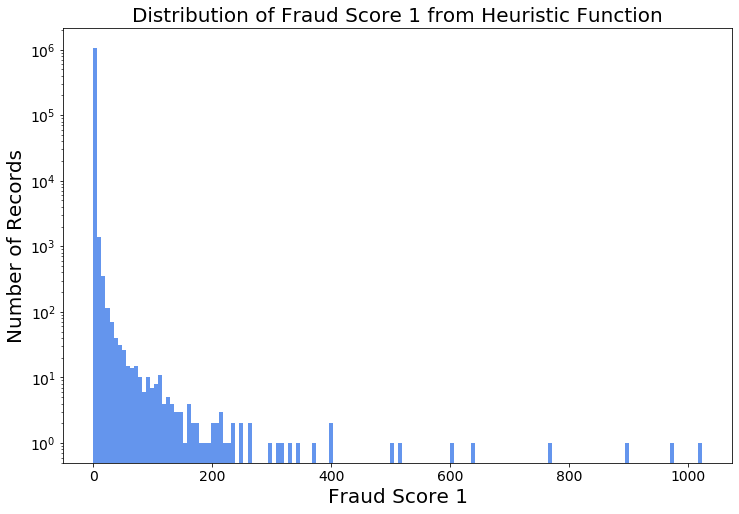

In [36]:
# Fraud Score 1 from Heuristic Function
plt.figure(figsize=(12,8))

plt.hist(combine_data["fraud_1"], bins=150, color="cornflowerblue")

plt.title("Distribution of Fraud Score 1 from Heuristic Function", fontsize=20)
plt.xlabel("Fraud Score 1", fontsize=20)
plt.ylabel("Number of Records", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')

plt.savefig("Score1.png")
plt.show()

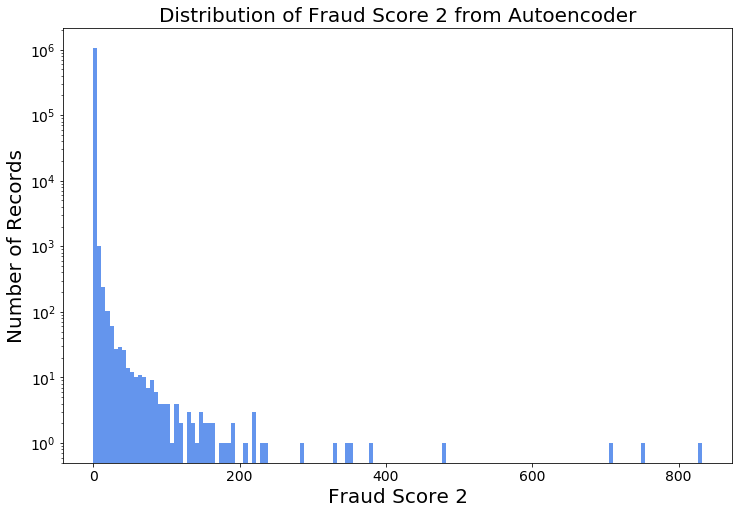

In [37]:
# Fraud Score 2 from Autoencoder
plt.figure(figsize=(12,8))

plt.hist(combine_data["fraud_2"], bins=150, color="cornflowerblue")

plt.title("Distribution of Fraud Score 2 from Autoencoder", fontsize=20)
plt.xlabel("Fraud Score 2", fontsize=20)
plt.ylabel("Number of Records", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')

plt.savefig("Score2.png")
plt.show()

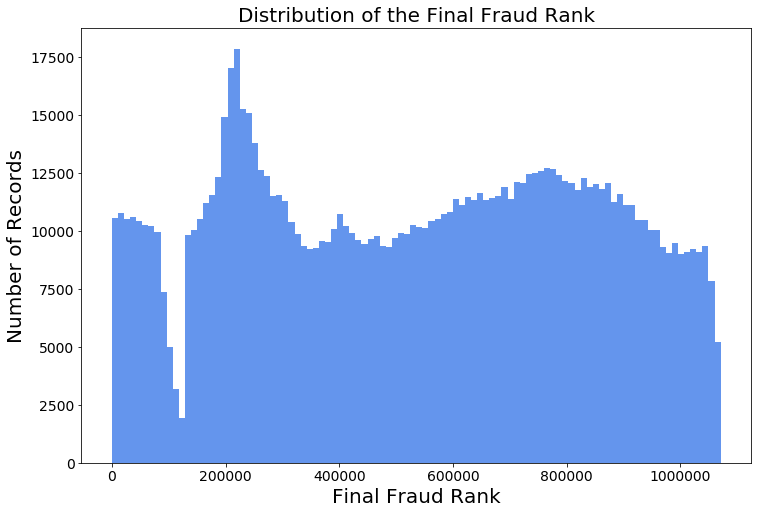

In [38]:
# final_rank 
plt.figure(figsize=(12,8))

plt.hist(combine_data["final_rank"], bins=100, color="cornflowerblue")

plt.title("Distribution of the Final Fraud Rank", fontsize=20)
plt.xlabel("Final Fraud Rank", fontsize=20)
plt.ylabel("Number of Records", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.yscale('log')

plt.savefig("FinalRank.png")
plt.show()

## 7.3 Create Summary tables for the top anomalous records

In [39]:
# read the dataset with RECORD field
old_data = pd.read_csv("NY_cleaned.csv")
old_data.head()

,RECORD,ZIP_new,STORIES,TAXCLASS,B,FULLVAL,AVLAND,AVTOT,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH
0,1,10004,50.0,4,1,21400000.0,4225500.0,9630000.0,500.0,1046.0,152.0,207.0
1,2,10004,50.0,4,1,193800000.0,14310000.0,87210000.0,27.0,207.0,152.0,207.0
2,3,10004,3.0,4,1,104686000.0,39008700.0,47108700.0,709.0,564.0,709.0,564.0
3,4,10004,2.0,4,1,39200000.0,15255000.0,17640000.0,793.0,551.0,85.0,551.0
4,5,10004,1.0,4,1,272300000.0,121050000.0,122535000.0,323.0,1260.0,89.0,57.0


In [40]:
fraud_index = [632815, 565391, 1067359, 917941, 556608, 85885, 585438, 750815, 185808, 935157, 585117, 920627]
fraud_data = old_data.iloc[fraud_index, :]
fraud_data.head(12)

,RECORD,ZIP_new,STORIES,TAXCLASS,B,FULLVAL,AVLAND,AVTOT,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH
632815,632816,11373,1.0,2,4,2.930000e+06,1.318500e+06,1.318500e+06,157.0,95.0,1.0,1.0
565391,565392,11225,2.0,4,3,4.326304e+09,1.946837e+09,1.946837e+09,117.0,108.0,42.0,85.0
1067359,1067360,10307,2.0,1,5,8.360000e+05,2.880000e+04,5.016000e+04,1.0,1.0,36.0,45.0
917941,917942,11422,3.0,4,4,3.740199e+08,1.792809e+09,4.668309e+09,4910.0,100.0,40.0,60.0
556608,556609,11236,1.0,4,3,1.360000e+08,6.075000e+07,6.120000e+07,35.0,50.0,88.0,62.0
85885,85886,10023,1.0,4,1,7.021400e+07,3.145500e+07,3.159630e+07,4000.0,150.0,8.0,8.0
585438,585439,11101,10.0,4,4,3.712000e+06,2.520000e+05,1.670400e+06,94.0,165.0,1.0,1.0
750815,750816,11367,2.0,1B,4,2.564350e+05,6.501000e+03,6.501000e+03,1.0,1.0,21.0,40.0
185808,185809,10462,1.0,4,2,5.303000e+04,2.386400e+04,2.386400e+04,1.0,3.0,55.0,75.0
935157,935158,10301,8.0,2,5,1.040000e+06,2.362500e+05,4.680000e+05,136.0,132.0,1.0,1.0


In [41]:
fraud_data.to_csv("fraud_record.csv")

In [42]:
origin = pd.read_csv("NY_v2.csv")
origin.head()

,Unnamed: 0,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,BB,BBL,ZIP_new
0,0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,11,11101,10004
1,1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,11,11201,10004
2,2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,12,121,10004
3,3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,12,1223,10004
4,4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,13,131,10004


In [43]:
origin.iloc[fraud_index, :]

,Unnamed: 0,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,BB,BBL,ZIP_new
632815,632815,632816,4018420001,4,1842,1,NaN,"864163 REALTY, LLC",D9,2,...,1.201200e+06,NaN,NaN,NaN,FINAL,2010/11,AC-TR,41842,418421,11373
565391,565391,565392,3085900700,3,8590,700,NaN,U S GOVERNMENT OWNRD,V9,4,...,8.484847e+08,8.484847e+08,8.484847e+08,NaN,FINAL,2010/11,AC-TR,38590,38590700,11225
1067359,1067359,1067360,5078530085,5,7853,85,NaN,NaN,B2,1,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,57853,5785385,10307
917941,917941,917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,414260,4142601,11422
556608,556608,556609,3083120001,3,8312,1,NaN,PARKS AND RECREATION,Q1,4,...,5.904000e+07,5.859000e+07,5.904000e+07,NaN,FINAL,2010/11,AC-TR,38312,383121,11236
85885,85885,85886,1012540010,1,1254,10,NaN,PARKS AND RECREATION,Q1,4,...,2.826018e+07,2.813400e+07,2.826018e+07,NaN,FINAL,2010/11,AC-TR,11254,1125410,10023
585438,585438,585439,4004590005,4,459,5,NaN,11-01 43RD AVENUE REA,H9,4,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,4459,44595,11101
750815,750815,750816,4066610005E,4,6661,5,E,M FLAUM,V0,1B,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,46661,466615,11367
185808,185808,185809,2038380139,2,3838,139,NaN,ZEREGA AVE URBAN RENE,V9,4,...,9.665000e+03,9.665000e+03,9.665000e+03,NaN,FINAL,2010/11,AC-TR,23838,23838139,10462
935157,935157,935158,5000130060,5,13,60,NaN,"RICH-NICH REALTY,LLC",D3,2,...,7.483500e+05,1.950080e+05,7.334780e+05,NaN,FINAL,2010/11,AC-TR,513,51360,10301


In [44]:
combine_data = pd.read_csv("nor_new_45.csv")

In [45]:
combine_data.iloc[fraud_index, :15]

,r1_all,r1_zip5,r1_zip3,r1_TAXCLASS,r1_B,r2_all,r2_zip5,r2_zip3,r2_TAXCLASS,r2_B,r3_all,r3_zip5,r3_zip3,r3_TAXCLASS,r3_B
632815,-0.014758,-0.016522,0.001747,0.239606,0.023383,366.179018,432.315435,393.182426,847.884517,350.688686,751.868093,527.956736,591.842835,1028.299819,599.384209
565391,316.664366,281.706397,212.589110,253.145519,210.810558,151.408453,143.253417,172.613684,73.885967,157.076898,155.430833,118.131862,150.439815,23.534911,146.998311
1067359,773.494505,664.507964,916.628916,632.043258,910.585011,-0.009523,-0.084592,-0.007208,-0.011295,-0.006441,-0.004025,-0.064582,-0.010959,-0.002961,-0.010558
917941,0.508413,1.645934,0.681733,0.389563,0.522575,19.406335,33.043081,21.523593,9.465021,18.577999,13.261189,15.877180,11.394249,2.006660,10.560195
556608,71.725505,109.887560,48.137093,57.325211,47.734407,3.041832,5.761316,3.465708,1.478659,3.153842,6.326798,8.181425,6.122236,0.956610,5.982298
85885,-0.088262,-0.121243,-0.104929,-0.087458,-0.102902,137.063830,305.469360,165.037716,66.885366,153.228477,281.481582,507.514487,525.221290,42.622334,526.680863
585438,0.024929,0.284441,0.014691,0.003034,0.061251,463.929831,229.834507,362.400077,226.405661,444.306469,95.192388,141.480671,93.786697,14.413215,75.876478
750815,237.125768,301.410828,199.766315,446.160825,226.294525,-0.035869,-0.058535,-0.045609,-0.020764,-0.042164,-0.031071,-0.046798,-0.038615,-0.006055,-0.036513
185808,16.162622,94.873587,19.402572,12.904572,19.228959,-0.072423,-0.109246,-0.083835,-0.041190,-0.076230,-0.066944,-0.077446,-0.065093,-0.011572,-0.063516
935157,-0.142949,-0.139383,-0.087873,-0.052056,-0.086978,129.927052,170.586843,159.881217,300.928521,145.565942,33.292209,41.649028,29.400332,45.612688,28.742938


In [46]:
combine_data.iloc[fraud_index, 15:30]

,r4_all,r4_zip5,r4_zip3,r4_TAXCLASS,r4_B,r5_all,r5_zip5,r5_zip3,r5_TAXCLASS,r5_B,r6_all,r6_zip5,r6_zip3,r6_TAXCLASS,r6_B
632815,0.447410,1.248562,0.533106,1.116778,0.587295,504.823256,459.870997,644.256126,991.131048,480.046997,873.576544,415.389444,785.224225,1031.937752,820.855633
565391,883.840284,409.192649,920.908618,469.828261,930.247917,208.787055,125.950577,434.030358,46.539007,377.964219,180.646370,104.394099,333.293988,18.836811,317.043721
1067359,165.165246,247.133947,250.154523,635.442729,256.415527,-0.007091,-0.035625,-0.007722,-0.000458,-0.006647,-0.006117,-0.029699,-0.007655,-0.000112,-0.007154
917941,20.887928,80.794011,31.196867,11.009885,26.076513,286.004484,300.763701,400.936511,63.755930,271.966622,164.966859,218.913113,192.291113,17.201320,155.008714
556608,199.095378,478.584534,207.458977,105.760021,209.562998,4.249374,29.162718,8.844316,0.933895,7.701964,7.365315,39.290373,13.595907,0.762287,12.933193
85885,0.241017,0.135375,0.019149,0.032242,0.021491,188.169320,266.459408,129.002125,41.941937,115.182560,325.627070,299.856888,304.541513,33.959395,298.577493
585438,0.033468,0.112813,0.035833,-0.078108,0.071111,96.473749,24.974501,34.472696,21.496868,91.736993,16.684566,23.763672,18.582053,1.734356,15.674874
750815,37.236355,99.914834,42.454071,421.095579,46.462916,-0.010935,-0.036699,-0.014249,-0.008651,-0.012764,-0.009443,-0.032797,-0.012715,-0.003737,-0.011694
185808,45.576010,329.131720,64.081539,24.136155,64.509938,-0.011683,-0.016625,-0.013146,-0.016180,-0.011452,-0.008174,0.005915,-0.008777,-0.006823,-0.008363
935157,0.015755,0.261770,0.069533,0.057591,0.072066,90.443271,104.813844,136.977357,177.578055,118.717555,19.554290,36.142804,24.451014,23.105879,23.072905
